In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *
from fastbook import *

In [3]:
path = untar_data(URLs.PETS)

In [4]:
# A convenience feature for viewing the realtive path when printing
Path.BASE_PATH = path

In [5]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [6]:
# The methods used here are enhanced versions of the Python List type, these enhancments
# belong to a class call 'L'

#The first letter in the images corresponds to cat breed if Uppercase, and dog breed, if lowercase


(path/"images").ls()

(#7393) [Path('images/basset_hound_41.jpg'),Path('images/British_Shorthair_108.jpg'),Path('images/Bengal_164.jpg'),Path('images/shiba_inu_179.jpg'),Path('images/miniature_pinscher_136.jpg'),Path('images/pomeranian_114.jpg'),Path('images/chihuahua_73.jpg'),Path('images/american_bulldog_147.jpg'),Path('images/shiba_inu_187.jpg'),Path('images/Birman_13.jpg')...]

In [7]:
# This time around we will be taking advantage of the regular expressions library (regex), which allow us
# to analyze strings, think of this as the control+F feature in documents 

# Lets give regex a shot by taking an example file

fname = (path/'images').ls()[0]

fname

Path('images/basset_hound_41.jpg')

In [8]:
# A quick cheatsheet for regex taken from the Chapter 7 of the "Automate the Boring Stuff with Python" book

# items in parentheses are called groups, which is what we want the fucntion to return 

# Placing an r before the quotation implies that we are not using escape characters such as '\n'

# The ? matches zero or one of the preceding group.
# The * matches zero or more of the preceding group.
# The + matches one or more of the preceding group.
# The {n} matches exactly n of the preceding group.
# The {n,} matches n or more of the preceding group.
# The {,m} matches 0 to m of the preceding group.
# The {n,m} matches at least n and at most m of the preceding group.
# {n,m}? or *? or +? performs a nongreedy match of the preceding group.
# ^spam means the string must begin with spam.
# spam$ means the string must end with spam.
# The . matches any character, except newline characters.
# \d , \w , and \s match a digit, word, or space character, respectively.
# \D , \W , and \S match anything except a digit, word, or space character,
# respectively.
# [abc] matches any character between the brackets (such as a, b, or c).
# [^abc] matches any character that isn’t between the brackets.

In [9]:
re.findall(r'(.+)_\d+\.jpg$', fname.name)

['basset_hound']

In [10]:
# We can now create a DataBlock
# The 'RegexLabeller' is a function that implements the regex code behind the curtains
# The 'using_attr'takes the 'RegexLabeller'function and changes it to a function that uses the 'name' attribute

# Notice that we use a 'Resize' function, this takes a 460X460 chunk of the image
# The 'aug_transforms'grabs chunks of the image, which give us a expanded dataset
# These resizing operations are somewhat unique to fastai as they preseve the quality of the images 

pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))

dls = pets.dataloaders(path/"images")

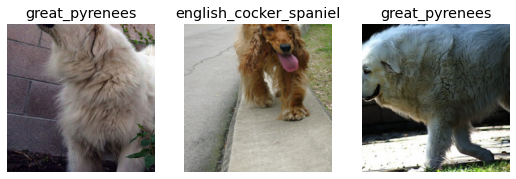

In [11]:
# Its always good to check progress along the way, the next three lines show some good ways to do so
dls.show_batch(nrows = 1, ncols = 3)

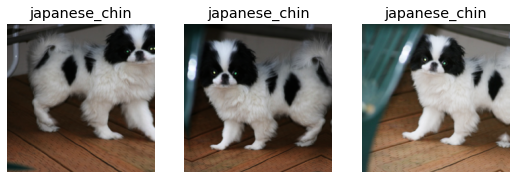

In [12]:
dls.show_batch(nrows = 1, ncols = 3, unique= True)

In [13]:
pets.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/slabban/.fastai/data/oxford-iiit-pet/images/japanese_chin_39.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x333
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/slabban/.fastai/data/oxford-iiit-pet/images/japanese_chin_39.jpg
    applying partial gives
      japanese_chin
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(23)

Final sample: (PILImage mode=RGB size=500x333, TensorCategory(23))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': Fal

In [14]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.466122,0.324229,0.106225,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.507361,0.302557,0.097429,00:37
1,0.310574,0.219727,0.071042,00:37


In [15]:
x,y = dls.one_batch()

In [16]:
y

TensorCategory([ 7, 35, 36, 26, 21, 29, 28, 11, 22, 18,  1,  6, 24, 30, 30, 32, 28, 36, 27, 31, 33, 25, 20,  6,  4, 16, 22, 10, 12, 12,  2, 10, 26, 19, 33, 11, 24, 31,  1, 17,  2, 28,  5, 30, 16, 29, 14,  8,
        14, 10, 11,  6,  4, 17,  4, 22, 28, 15,  8, 35,  1, 17, 20, 11], device='cuda:0')

In [17]:
dls.vocab[5]

'Egyptian_Mau'

In [18]:
# An important thing is the use of a new type of loss function called Cross-Entropy Loss.
# Cross-Entropy loss comprises of two parts

# 1. Softmax. This is a extension of  sigmoid fucntion that allows us to get predictions for multiple 
# clasification i.e have an output layer that comprises of more than one neuron. 
# The basic Sigmoid falls short as taking the sum of the predictions for 2 or more classes will give us
# a value that is greater than one, which does not make any sense.
# The Softmax modification correts for this and sums the predictions to one, as see below.
# An interesting observation about Softmax is that it exponentially increases the output.

# 2. Log Likelihood. In a nutshell, this uses indexing to enumerate individual classes with their 
# own unique value, this enables us to assign predictions to multiple classes, and hence, have their own
# prediction

# Interstingly enough, we don't actually take the natural log, it is found to be much more efficient and accurate 
# to take the nautal log during the Softmax portion. The reason we take the log is to give our model the ability
# To further train our model beyond the restriction of 0 to 1, from -infinity to 0 (ln(0) - ln(1))

In [19]:
preds,_ = learn.get_preds(dl=[(x,y)])

preds[0]

TensorBase([2.0440e-09, 1.3278e-09, 9.9812e-08, 2.9421e-09, 1.8535e-05, 5.0041e-09, 7.9401e-08, 9.9992e-01, 4.1799e-07, 1.7561e-08, 3.5273e-10, 9.5259e-09, 8.5277e-08, 1.0562e-09, 2.6931e-07, 8.9465e-09,
        2.3536e-07, 2.2690e-09, 1.9520e-08, 2.3287e-10, 8.8373e-10, 1.0718e-07, 1.1076e-05, 3.1224e-07, 2.2103e-07, 1.0086e-08, 3.7452e-09, 2.5874e-08, 6.5645e-06, 8.0433e-07, 2.3837e-09, 3.9770e-05,
        2.3940e-08, 1.8989e-08, 7.8202e-09, 5.7627e-08, 8.1625e-08])

In [20]:
# Using the Cross-Entropy Loss, we achieve summed prediction of 1, which is what we want 
len(preds[0]), preds[0].sum()

(37, TensorBase(1.0000))

In [21]:
# Lets vizualize the log funtion to aid in explaining it's benefit as explained above
#plot_function(torch.sigmoid, min=-4,max=4)

TypeError: linspace() missing 1 required positional arguments: "steps"

In [1]:
# Now that we have given a brief explanation on Cross-Entropy Loss let get back to analyzing our trained model

# As seen before, we can use the confusion matrix in order to visualize the results:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

NameError: name 'ClassificationInterpretation' is not defined

In [ ]:
# Although comprehensive, it can be tricky to read in this state, we can use the most confused method

# ClassificationInterpretation?? (Using the ?? is pretty handy for understanding what type something is)

# The 'most_confused' method is really helpful to find our false predictions

# A decent first step would be to analyze these errors by looking at the data, 
# For example 'american_pit_bull_terrier' and 'staffordshire_bull_terrier' are fairly close in appearance, 
# and hence, It could be reasonable that that our model confused the two in its predictions

interp.most_confused(min_val= 4)

In [ ]:
# A modest first step to improve the performance of the model may be to train it at higher epochs 
# with a higher learning rate,our first try was with a default value of (0.002)

# But look whats happened to our error rate. Its gotten worse!, what is happening here is
# that our model is overstepping, causing it to oscillate and stop decreasing due to our big steps

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

In [ ]:
# One neat method of the cnn_learner class is called the 'lr_find', which can help us optimize our 
# learning rate so that we avoid cumbersome computations early in the the model or overstepping

# This ideal learning rate is NOT optimal for every epoch as we will see below

# The method used here has been improved since the book, refer to this line for the improvment

learn = cnn_learner(dls, resnet34, metrics=error_rate)
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
# Ideally, we would like to experiment with values between the Steepest Point and Minimum
# One solid approach would be to download the minimum by 10
print(f"Minimum/10: {lrs.minimum:.2e}, steepest point: {lrs.steep:.2e}")

In [ ]:
# One special point about the models we've been training using the resnet model, is that
# we have been employing an popular concept called Transfer Learning. 
# Transfer Learning is the practice of replacing the last layer of a pre-trained neural net with
# our own output layer

# Two major steps occur here:
# 1. Train the randomly added layers for one epoch, with all the pre-trained layers' paramaters frozen
# 2. Divide the specified learning rate by two, unfreeze the entire models' paramters, and train 
# for a specified number of epochs

learn.fine_tune??

In [ ]:
# Lets dissect the fine_tune method to understand how our learning rate changes

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

In [ ]:
learn.unfreeze()

In [ ]:
# We can see now the the graph has changed significantly, implying that we need to update the learning rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
# Taking the factor of ten approach, we choose an error rate of 1e-5, and see the error_rate decrease further
learn.fit_one_cycle(3, 1e-5)

In [ ]:
# The idea of changing the learning rate as the epochs progress is known as the process of using
# Discriminative Learning Rates

# We find that using the constructs of fine_tune with is much more effective and efficient
# at giving us better due to the fact that we can employ the Discriminative Learning Rates
# via the 'lr_max=slice()' method

# Lets train our model using this:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(8, lr_max=slice(1e-6,1e-4))

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# A handy tool for training over large models can be to use the 'to_fp16()' method
# This converts the values used in operations from 32 to 16 bits, the sacrifice is some accuracy
# but this can pay off:


# from fastai.callback.fp16 import *
# learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
# learn.fine_tune(6, freeze_epochs=3)